In [1]:
!pip install datasets
!pip install transformers
!pip install accelerate
!pip install torch_tb_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 34.9 MB/s eta 0:00

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/EEP590_Embed_DL/final/

Mounted at /content/drive
/content/drive/MyDrive/EEP590_Embed_DL/final


In [2]:
from datasets import load_dataset
from datasets import Dataset
from transformers import BartTokenizer, BartModel, BartForConditionalGeneration, BartConfig, DataCollatorWithPadding, AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as torchDataset
from tqdm.notebook import tqdm_notebook
from transformers import Trainer
from transformers import TrainingArguments
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load the CNN/Daily Mail dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")

# Access the training, validation, and test splits
train_dataset = dataset["train"]
validation_dataset = dataset["validation"]
test_dataset = dataset["test"]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))
print(type(train_dataset))

287113
13368
11490
<class 'datasets.arrow_dataset.Dataset'>


In [3]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

In [7]:
# Helper Fucntion to tokenize the data set ahead of time
def encode(input, tokenizer):
  # Tokenize the input and target text
  tokenized_text = tokenizer.batch_encode_plus(input['article'], return_tensors="pt", truncation=True, padding='max_length', max_length=128)
  tokenized_summary = tokenizer.batch_encode_plus(input['highlights'], return_tensors="pt", truncation=True, padding='max_length', max_length=128)

  # Return the tokenized input
  return {'input_ids': tokenized_text['input_ids'], 'attention_mask': tokenized_text['attention_mask'],
          'decoder_input_ids': tokenized_summary['input_ids'], 'decoder_attention_mask': tokenized_summary['attention_mask']}

In [ ]:
# Pre Tokenize the dataset
tokenized_train_dataset = train_dataset.map(encode, batched=True, fn_kwargs={'tokenizer': tokenizer})
tokenized_valid_dataset = validation_dataset.map(encode, batched=True, fn_kwargs={'tokenizer': tokenizer})
tokenized_test_dataset = test_dataset.map(encode, batched=True, fn_kwargs={'tokenizer': tokenizer})

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_dataset.save_to_disk('tokenized_train_dataset')
tokenized_valid_dataset.save_to_disk('tokenized_valid_dataset')
tokenized_test_dataset.save_to_disk('tokenized_test_dataset')

Saving the dataset (0/5 shards):   0%|          | 0/287113 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/13368 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/11490 [00:00<?, ? examples/s]

# Load Pre-Tokenized Dataset

In [4]:
# Load Tokenized Datasets
# tokenized_train_dataset_load = Dataset.load_from_disk('tokenized_train_dataset')
# tokenized_valid_dataset_load = Dataset.load_from_disk('tokenized_valid_dataset')
tokenized_test_dataset_load = Dataset.load_from_disk('tokenized_test_dataset')

In [ ]:
# Input is 512 - Trains slow bc small batch size
tokenized_train_dataset_load = Dataset.load_from_disk('tokenized_train_dataset_512')
tokenized_valid_dataset_load = Dataset.load_from_disk('tokenized_valid_dataset_512')
tokenized_test_dataset_load = Dataset.load_from_disk('tokenized_test_dataset_512')

In [ ]:
# Verify 
print(tokenized_train_dataset_load['article'][0])
print(tokenizer.decode(tokenized_train_dataset_load['input_ids'][0], skip_special_tokens=True))

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how

In [5]:
# Load into a torch data loader
batch_size = 1
# train_loader = DataLoader(tokenized_train_dataset_load, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(tokenized_valid_dataset_load, batch_size=batch_size)
test_loader = DataLoader(tokenized_test_dataset_load, batch_size=batch_size)

In [ ]:
# Fine Tuning - Load Model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base').to(device)
config = BartConfig.from_pretrained("facebook/bart-base")
model.config = config

In [ ]:
# Load model from a checkpoint
filepath = 'trainer/checkpoint-4500'
model = BartForConditionalGeneration.from_pretrained(filepath).to(device)
config = BartConfig.from_pretrained(filepath)
model.config = config

In [ ]:
for e in train_loader:
  # print(e['input_ids'])
  print(type(e['input_ids']))
  break

<class 'list'>


In [ ]:
# Fine Tuning - Train
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 4

losses = []
loss_avg = 0
valid_losses = []
loss_avg_valid = 0
i = 0
for epoch in tqdm_notebook(range(num_epochs)):
  model.train()
  for batch in tqdm_notebook(train_loader, total=len(train_loader)):
    input_ids = torch.stack(batch['input_ids']).to(device)
    attention_mask =  torch.stack(batch['attention_mask']).to(device)
    decoder_input_ids =  torch.stack(batch['target_ids']).to(device)
    decoder_attention_mask =  torch.stack(batch['target_attention_mask']).to(device)

    optimizer.zero_grad()

    outputs = model(input_ids=input_ids,
                    attention_mask=attention_mask,
                    decoder_input_ids=decoder_input_ids,
                    decoder_attention_mask=decoder_attention_mask,
                    labels=decoder_input_ids)

    loss = outputs.loss
    loss.backward()
    optimizer.step()
    loss_avg += loss.item()
    i += 1
    if i >150:
      break
  # losses.append(loss_avg/(len(train_loader)))
  losses.append(loss_avg/i)
  loss_avg = 0
  i = 0

  for batch in tqdm_notebook(valid_loader, total=len(valid_loader)):
    input_ids = torch.stack(batch['input_ids']).to(device)
    attention_mask =  torch.stack(batch['attention_mask']).to(device)
    decoder_input_ids =  torch.stack(batch['target_ids']).to(device)
    decoder_attention_mask =  torch.stack(batch['target_attention_mask']).to(device)
    outputs = model(input_ids=input_ids,
                    attention_mask=attention_mask,
                    decoder_input_ids=decoder_input_ids,
                    decoder_attention_mask=decoder_attention_mask,
                    labels=decoder_input_ids)
    loss = outputs.loss
    loss_avg_valid += loss.item()
  valid_losses.append(loss_avg_valid/len(valid_loader))
  loss_avg_valid = 0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/35890 [00:00<?, ?it/s]

  0%|          | 0/1671 [00:00<?, ?it/s]

  0%|          | 0/35890 [00:00<?, ?it/s]

  0%|          | 0/1671 [00:00<?, ?it/s]

  0%|          | 0/35890 [00:00<?, ?it/s]

  0%|          | 0/1671 [00:00<?, ?it/s]

  0%|          | 0/35890 [00:00<?, ?it/s]

  0%|          | 0/1671 [00:00<?, ?it/s]

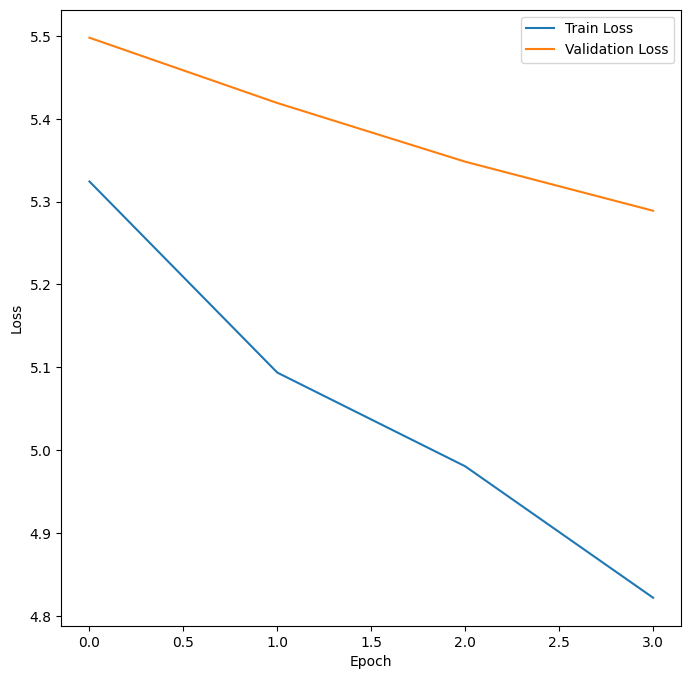

In [ ]:
plt.figure(figsize=(8,8));
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend();

In [ ]:
# Fine tuning using Hugging Face Trainer
training_args = TrainingArguments("trainer", per_device_train_batch_size=50, logging_steps = 300, report_to='none',  evaluation_strategy="steps", eval_steps=300, learning_rate=1e-5) # Specify file where model will be saved
training_args.num_train_epochs=20
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# print(training_args)

In [ ]:
# Fix dataset?

# tokenized_train_dataset_load = tokenized_train_dataset_load.rename_column('target_ids', 'decoder_input_ids')
# tokenized_train_dataset_load = tokenized_train_dataset_load.rename_column('target_attention_mask', 'decoder_attention_mask')

# tokenized_valid_dataset_load = tokenized_valid_dataset_load.rename_column('target_ids', 'decoder_input_ids')
# tokenized_valid_dataset_load = tokenized_valid_dataset_load.rename_column('target_attention_mask', 'decoder_attention_mask')

tokenized_train_dataset_load = tokenized_train_dataset_load.add_column('labels', tokenized_train_dataset_load['decoder_input_ids'])
tokenized_valid_dataset_load = tokenized_valid_dataset_load.add_column('labels', tokenized_valid_dataset_load['decoder_input_ids'])


In [ ]:
training_subset = Dataset.from_dict(tokenized_train_dataset_load[:15000])
# training_subset = Dataset.from_dict(tokenized_train_dataset_load[:5000])
print(training_subset)
# print(len(tokenized_train_dataset_load))

Dataset({
    features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask', 'labels'],
    num_rows: 15000
})


In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=training_subset,
    eval_dataset=tokenized_valid_dataset_load,
    data_collator=data_collator,
    tokenizer= tokenizer
)

In [ ]:
print(tokenized_train_dataset_load)
print(tokenized_valid_dataset_load)


Dataset({
    features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask'],
    num_rows: 287113
})
Dataset({
    features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask'],
    num_rows: 13368
})


In [ ]:
# model.train()
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
300,2.929400,0.170977
600,0.094400,0.036867
900,0.033900,0.034740
1200,0.027700,0.033727
1500,0.016900,0.009867
1800,0.003900,0.007591
2100,0.002800,0.008011
2400,0.002300,0.007614
2700,0.001700,0.007482
3000,0.001200,0.008063


In [ ]:
!nvidia-smi
torch.cuda.empty_cache()

Wed May 24 08:52:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    29W /  70W |  15063MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
losses = []
epochs_list = []
eval_losses = []
eval_acc = []

for item in (trainer.state.log_history):
  if 'loss' in item:
    losses.append(item['loss'])
    epochs_list.append(item['epoch'])
  if 'eval_loss' in item:
    eval_losses.append(item['eval_loss'])
  # if 'eval_accuracy' in item:
  #   eval_acc.append(item['eval_accuracy'])

plt.figure(figsize=(8,8));
plt.plot(epochs_list, losses, label='Train Loss')
plt.plot(epochs_list, eval_losses, label='Validation Loss')
plt.title('Losses per Epoch')
plt.xlabel('Epochs')
plt.legend();

In [ ]:

# Generate the summary
# List to store generated summaries
original_text = []
generated_summaries = []

# Iterate over the batches in the DataLoader
for batch in test_loader:
    # Move the batch to the appropriate device
    batch = {key: torch.tensor(value) if isinstance(value, torch.Tensor) and key !='labels' else value
        for key, value in batch.items()}

    # Pass the batch through the model to obtain the output
    with torch.no_grad():
        outputs = model.generate(
            input_ids=torch.stack(batch["input_ids"]).to(device),
            attention_mask=torch.stack(batch["attention_mask"]).to(device),
            max_length=100,  # Adjust the maximum length as per your requirement
            num_beams=4,  # Adjust the number of beams for beam search decoding
        )

    # # Decode the generated output tokens back to text
    decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # # Add the decoded outputs to the list of generated summaries
    generated_summaries.extend(decoded_outputs)
    original_text.extend(batch['article'])
    break

In [ ]:
# Generate the summary - On CPU - THIS CRASHES THE COLAB, TOO MUCH RAM USAGE

# List to store generated summaries
original_text = []
generated_summaries = []

test_model = model.to(torch.device("cpu"))
# Iterate over the batches in the DataLoader
for batch in test_loader:
    # Move the batch to the appropriate device
    batch = {key: torch.tensor(value).to(torch.device("cpu")) if isinstance(value, torch.Tensor) and key !='labels' else value
        for key, value in batch.items()}

    # Pass the batch through the model to obtain the output
    with torch.no_grad():
        outputs = model.generate(
            input_ids=torch.stack(batch["input_ids"]).to(torch.device("cpu")),
            attention_mask=torch.stack(batch["attention_mask"]).to(torch.device("cpu")),
            max_length=100,  # Adjust the maximum length as per your requirement
            num_beams=6,  # Adjust the number of beams for beam search decoding
        )

    # # Decode the generated output tokens back to text
    decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # # Add the decoded outputs to the list of generated summaries
    generated_summaries.extend(decoded_outputs)
    original_text.extend(batch['article'])
    break

In [ ]:
# # Iterate over the decoded outputs for each example
# for decoded_output in decoded_outputs:
#     # Initialize an empty summary
#     summary = ""
#     # Iterate over the tokens in the decoded output
#     for token in decoded_output:
#         # Check if the token is the end token or exceeds the maximum length
#         if token == tokenizer.eos_token_id or len(summary.split()) >= 100:
#             break
#         # Concatenate the token to the summary
#         summary += token 
#     # Print or process the reconstructed summary
#     print(summary.strip())

In [ ]:
print(len(batch['input_ids']))

128


In [ ]:
print(len(batch))
print(len(decoded_outputs), len(decoded_outputs[0]))
print(original_text[6])
print()
print(batch['highlights'][6])
print()
# print(generated_summaries)
print(decoded_outputs[6])

7
128 519
(CNN)Governments around the world are using the threat of terrorism -- real or perceived -- to advance executions, Amnesty International alleges in its annual report on the death penalty. "The dark trend of governments using the death penalty in a futile attempt to tackle real or imaginary threats to state security and public safety was stark last year," said Salil Shetty, Amnesty's Secretary General in a release. "It is shameful that so many states around the world are essentially playing with people's lives -- putting people to death for 'terrorism' or to quell internal instability on the ill-conceived premise of deterrence." The report, "Death Sentences and Executions 2014," cites the example of Pakistan lifting a six-year moratorium on the execution of civilians following the horrific attack on a school in Peshawar in December. China is also mentioned, as having used the death penalty as a tool in its "Strike Hard" campaign against terrorism in the restive far-western pro

In [ ]:
original_text = test_loader.dataset['article'][0]
original_summary = test_loader.dataset['highlights'][0]
inputs = tokenizer.encode_plus(original_text, return_tensors="pt", max_length=128, truncation=True)

# Pass the batch through the model to obtain the output

outputs = model.generate(
    input_ids=inputs['input_ids'].to(device),
    attention_mask=inputs["attention_mask"].to(device),
    max_length=60,  # Adjust the maximum length as per your requirement
    num_beams=4,  # Adjust the number of beams for beam search decoding
)

# Decode the generated output tokens back to text
decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)


print(original_text)
print()
print(original_summary)
print()
print(decoded_outputs)

(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednesday's ceremony, sa

# Test BART-Large-CNN

In [ ]:
tokenizer_cnn = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model_cnn = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn").to(device)

In [ ]:

# Generate the summary

# List to store generated summaries
original_text = test_loader.dataset['article'][0]
original_summary = test_loader.dataset['highlights'][0]
inputs = tokenizer.encode_plus(original_text, return_tensors="pt", max_length=512, truncation=True)

# Pass the batch through the model to obtain the output

outputs = model_cnn.generate(
    input_ids=inputs['input_ids'].to(device),
    attention_mask=inputs["attention_mask"].to(device),
    max_length=100,  # Adjust the maximum length as per your requirement
    num_beams=4,  # Adjust the number of beams for beam search decoding
)

# Decode the generated output tokens back to text
decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)


print(original_text)
print()
print(original_summary)
print()
print(decoded_outputs)

(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednesday's ceremony, sa

# Optimum 


## Better Transformer

In [ ]:
from optimum.bettertransformer import BetterTransformer

In [ ]:
# Test with My Model
bt_model = BetterTransformer.transform(model, keep_original_model=True)

In [ ]:
print("converted_model: ", bt_model)

converted_model:  BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayerBetterTransformer()
      )
      (layernorm_embedding): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): BartDecoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartDecoderLayer(
          (self_attn): BartAttentionLayerBetterTransformer(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_feature

In [ ]:
print("original_model: ", model)

original_model:  BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): Layer

In [ ]:
def benchmark(model, input_ids, masks, NUM_BATCHES):
    """
    Utility function to benchmark the execution time on CUDA device
    """
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()
    for _ in range(NUM_BATCHES):
        _ = model(input_ids, masks)
    end_event.record()
    torch.cuda.synchronize()

    return (start_event.elapsed_time(end_event) * 1.0e-3) / NUM_BATCHES

def print_device():
    if torch.cuda.is_available():
        device_index = torch.cuda.current_device()
        print(f"Using {torch.cuda.get_device_name(device_index)}")
    else:
        print("Using CPU.")

In [ ]:
SEQ_LEN = 128
BATCH_SIZE = 1
NUM_BATCHES = 500

input_ids = torch.randint(0, 3000, (BATCH_SIZE, SEQ_LEN)).to(0)
masks = torch.ones((BATCH_SIZE, SEQ_LEN)).to(0)

print_device()

# warmup
_ = model(input_ids, masks)
_ = bt_model(input_ids, masks)

# Benchmark HF
total_time_hf = benchmark(model, input_ids, masks, NUM_BATCHES)

# Benchmark BT
total_time_bt = benchmark(bt_model, input_ids, masks, NUM_BATCHES)

speedup = total_time_hf / total_time_bt

print(f"\nModel using BetterTransformer is {speedup:.2f}x faster than the original PyTorch model (throughput).")

Using Tesla T4


/usr/local/lib/python3.10/dist-packages/optimum/bettertransformer/models/encoder_models.py:378: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  hidden_states = torch._nested_tensor_from_mask(hidden_states, ~attention_mask)



Model using BetterTransformer is 1.37x faster than the original PyTorch model (throughput).


In [ ]:
# Test with Bart-large-cnn
tokenizer_cnn = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model_cnn = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn").to(device) 

In [ ]:
# Test using 

In [ ]:
bt_model_cnn = BetterTransformer.transform(model_cnn, keep_original_model=True)

In [ ]:
SEQ_LEN = 128
BATCH_SIZE = 1
NUM_BATCHES = 500

input_ids = torch.randint(0, 3000, (BATCH_SIZE, SEQ_LEN)).to(0)
masks = torch.ones((BATCH_SIZE, SEQ_LEN)).to(0)

print_device()

# warmup
_ = model_cnn(input_ids, masks)
_ = bt_model_cnn(input_ids, masks)

# Benchmark HF
total_time_hf = benchmark(model_cnn, input_ids, masks, NUM_BATCHES)

# Benchmark BT
total_time_bt = benchmark(bt_model_cnn, input_ids, masks, NUM_BATCHES)

speedup = total_time_hf / total_time_bt

print(f"\nModel using BetterTransformer is {speedup:.2f}x faster than the original PyTorch model (throughput).")

Using Tesla T4

Model using BetterTransformer is 1.08x faster than the original PyTorch model (throughput).


## Optimum Intel Neurocompressor

In [6]:
!pip install optimum[neural-compressor]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 10.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8

In [ ]:
from neural_compressor.config import PostTrainingQuantConfig
from optimum.intel import INCQuantizer, INCModelForSeq2SeqLM
from optimum.intel.neural_compressor import  INCModel
from torch.profiler import profile, record_function, ProfilerActivity


/usr/local/lib/python3.10/dist-packages/optimum/intel/neural_compressor/quantization.py:657: UserWarning: The class `IncQuantizer` has been depreciated and will be removed in optimum-intel v1.7, please use `INCQuantizer` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optimum/intel/neural_compressor/trainer.py:817: UserWarning: The class `IncTrainer` has been depreciated and will be removed in optimum-intel v1.7, please use `INCTrainer` instead.
  warnings.warn(


In [ ]:
with profile(
          activities=[torch.profiler.ProfilerActivity.CPU], 
          record_shapes=True, 
          profile_memory=True
        ) as prof_inference:
  with record_function("model_inference"):
    with torch.no_grad():
        for data in test_loader:
          input_ids = torch.stack(data['input_ids'])
          attention = torch.stack(data['attention_mask'])
          outputs = model_cnn(input_ids=input_ids, attention_mask=attention)
          # outputs = model_cnn.generate(input_ids=input_ids, attention_mask=attention,
          #                              max_length=100,  # Adjust the maximum length as per your requirement
          #                              num_beams=4,  # Adjust the number of beams for beam search decoding
          # )
          break

for entry in prof_inference.key_averages():
  if "model_inference" in entry.key:
    orig_model_time = entry.cpu_time_total

memory = sum([stats.self_cpu_memory_usage for stats in prof_inference.key_averages()])

# Decode the generated output tokens back to text
# decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)

print('Original Model Time for 1 input: ' + str(orig_model_time/1000000) + ' seconds')
print('Original Memory Use for 1 input: ' + str(memory) + ' bytes')
# print('Original Text: \n' + str(data['article']))
# print('Original Summary: \n' + str(data['highlights']))
# print('Generated Summary: \n' + decoded_outputs)

Original Model Time for 1 input: 2.283586 seconds
Original Memory Use for 1 input: 51431424 bytes


In [ ]:
# print(outputs.logits)
# predicted_token_ids = outputs.logits.argmax(dim=-1)
# predicted_text = tokenizer.batch_decode(predicted_token_ids, skip_special_tokens=True)
# print(predicted_text)

In [ ]:
save_dir = "dynamic_quantization_large_cnn"

# Load the quantization configuration detailing the quantization we wish to apply
quantization_config = PostTrainingQuantConfig(approach="dynamic")
quantizer = INCQuantizer.from_pretrained(model_cnn)
# Apply dynamic quantization and save the resulting model
quantizer.quantize(quantization_config=quantization_config, save_directory=save_dir)

2023-05-26 06:32:28 [WARNING] Force convert framework model to neural_compressor model.
2023-05-26 06:32:28 [INFO] Start auto tuning.
2023-05-26 06:32:36 [INFO] Pass query framework capability elapsed time: 7118.35 ms
2023-05-26 06:32:36 [INFO] Adaptor has 1 recipes.
2023-05-26 06:32:36 [INFO] 0 recipes specified by user.
2023-05-26 06:32:36 [INFO] 0 recipes require future tuning.
2023-05-26 06:32:36 [INFO] *** Initialize auto tuning
2023-05-26 06:32:36 [INFO] Get FP32 model baseline.
2023-05-26 06:32:36 [INFO] Save tuning history to /content/drive/MyDrive/EEP590_Embed_DL/final/nc_workspace/2023-05-26_05-48-59/./history.snapshot.
2023-05-26 06:32:36 [INFO] FP32 baseline is: [Accuracy: 1.0000, Duration (seconds): 0.0000]
2023-05-26 06:32:36 [INFO] Quantize the model with default config.
2023-05-26 06:32:42 [INFO] Fx trace of the entire model failed, We will conduct auto quantization
2023-05-26 06:33:17 [INFO] |Mixed Precision Statistics|
2023-05-26 06:33:17 [INFO] +-----------+-------+-

In [ ]:
# Load the Quantized Model
save_dir = "dynamic_quantization_large_cnn"
quant_model = INCModelForSeq2SeqLM.from_pretrained(save_dir)

# quant_model = AutoModelForSeq2SeqLM.from_pretrained(save_dir)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:335: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  total = next(it)
loading configuration file dynamic_quantization_large_cnn/inc_config.json
INCConfig {
  "distillation": {},
  "neural_compressor_version": "2.1.1",
  "optimum_version": "1.8.6",
  "pruning": {},
  "quantization": {
    "dataset_num_samples": null,
    "is_static": false
  },
  "save_onnx_model": false,
  "torch_version": "1.13.1",
  "transformers_version": "4.29.2"
}



╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553 in run_code        │
│                                                                                                  │
│   3550 │   │   │   │   elif async_ :                                                             │
│   3551 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3552 │   │   │   │   else:                                                                     │
│ ❱ 3553 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3554 │   │   │   finally:                                                                      │
│   3555 │   │   │   │   # Reset our crash handler in place                                        │
│   3556 │   │   │   │   sys.excepthook = old_excepthook                                           │
│ in <cell line: 3>:3                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/optimum/intel/neural_compressor/quantization.py:564 in   │
│ from_pretrained                                                                                  │
│                                                                                                  │
│   561 │   │                                                                                      │
│   562 │   │   if "best_configure" in state_dict and state_dict["best_configure"] is not None:    │
│   563 │   │   │   try:                                                                           │
│ ❱ 564 │   │   │   │   model = load(state_dict_path, model)                                       │
│   565 │   │   │   except Exception as e:                                                         │
│   566 │   │   │   │   if msg is not None:                                                        │
│   567 │   │   │   │   │   e.args += (msg,)                                                       │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/neural_compressor/utils/pytorch.py:291 in load           │
│                                                                                                  │
│   288 │   │   # For torch.fx approach                                                            │
│   289 │   │   assert version.release >= Version("1.8.0").release, \                              │
│   290 │   │   │   │   │     "Please use PyTroch 1.8 or higher version with pytorch_fx backend"   │
│ ❱ 291 │   │   from torch.quantization.quantize_fx import prepare_fx, convert_fx, prepare_qat_f   │
│   292 │   │   if kwargs is None:                                                                 │
│   293 │   │   │   kwargs = {}                                                                    │
│   294 │   │   prepare_custom_config_dict = kwargs.get(                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/quantization/quantize_fx.py:10 in <module>         │
│                                                                                                  │
│    7 here.                                                                                       │
│    8 """                                                                                         │
│    9                                                                                             │
│ ❱ 10 from torch.ao.quantization.quantize_fx import (                                             │
│   11 │   _check_is_graph_module,                           

In [ ]:
with profile(
          activities=[torch.profiler.ProfilerActivity.CPU], 
          record_shapes=True, 
          profile_memory=True
        ) as prof_inference:
  with record_function("model_inference"):
    with torch.no_grad():
        for data in test_loader:
          input_ids = torch.stack(data['input_ids'])
          attention = torch.stack(data['attention_mask'])
          outputs = quant_model(input_ids=input_ids, attention_mask=attention)
          # outputs = quant_model.generate(input_ids=input_ids, attention_mask=attention,
          #                              max_length=100,  # Adjust the maximum length as per your requirement
          #                              num_beams=4,  # Adjust the number of beams for beam search decoding
          # )
          break

for entry in prof_inference.key_averages():
  if "model_inference" in entry.key:
    orig_model_time = entry.cpu_time_total

memory = sum([stats.self_cpu_memory_usage for stats in prof_inference.key_averages()])

# Decode the generated output tokens back to text
# decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)

print('Original Model Time for 1 input: ' + str(orig_model_time/1000000) + ' seconds')
print('Original Memory Use for 1 input: ' + str(memory) + ' bytes')
# print('Original Text: \n' + str(data['article']))
# print('Original Summary: \n' + str(data['highlights']))
# print('Generated Summary: \n' + decoded_outputs)

Original Model Time for 1 input: 1.579204 seconds
Original Memory Use for 1 input: 51431424 bytes


In [ ]:
# seq_output =quant_model.generate(input_ids=input_ids, attention_mask=attention,
#                                        max_length=60,  # Adjust the maximum length as per your requirement
#                                        num_beams=1,  # Adjust the number of beams for beam search decoding
#           )
# decoded_outputs = tokenizer.batch_decode(seq_output, skip_special_tokens=True)
# print('Generated Summary: \n' + str(decoded_outputs))


original_text = test_loader.dataset['article'][0]
original_summary = test_loader.dataset['highlights'][0]
inputs = tokenizer.encode_plus(original_text, return_tensors="pt", max_length=128, truncation=True)

# Pass the batch through the model to obtain the output

outputs = quant_model.generate(
    input_ids=inputs['input_ids'].to(device),
    attention_mask=inputs["attention_mask"].to(device),
    max_length=60,  # Adjust the maximum length as per your requirement
    num_beams=2,  # Adjust the number of beams for beam search decoding
)

# Decode the generated output tokens back to text
decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)


print(original_text)
print()
print(original_summary)
print()
print(decoded_outputs)

(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednesday's ceremony, sa

In [ ]:
print(outputs.shape)
print(outputs)

torch.Size([1, 60])
tensor([[    2,     0,     0, 29743, 10203,   837,  3374,     5, 17072,  2586,
           919,     9,     5,  1016, 10203,   837,     4,    20,   517,  2029,
             5,   461, 10542,    81,  1697,  3474,    11,     5,  5791, 13560,
             4,    20,   461,    40,    67,    33,     5,   476,     7,  4830,
          1697,  3474,  2021,    11,     5,   580,   788,     8,  7914,     4,
            20, 14305,    16,   716,    11,    20, 24852,     6,     5,     2]])


## ONNX Runtime 


In [7]:
!pip install optimum[onnxruntime]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: onnx
    Found existing installation: onnx 1.14.0
    Uninstalling onnx-1.14.0:
      Successfully uninstalled onnx-1.14.0


In [ ]:
from optimum.exporters.tasks import TasksManager

bart_tasks = list(TasksManager.get_supported_tasks_for_model_type("bart", "onnx").keys())
print(bart_tasks)

['feature-extraction', 'feature-extraction-with-past', 'text-generation', 'text-generation-with-past', 'text2text-generation', 'text2text-generation-with-past', 'text-classification', 'question-answering']


In [6]:
from transformers import AutoConfig, AutoModelForSeq2SeqLM
from transformers.models.bart import BartOnnxConfig

model_ckpt = "facebook/bart-large-cnn"
config = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)
onnx_config = BartOnnxConfig(config, task="seq2seq-lm")
onnx_config.outputs

OrderedDict([('logits', {0: 'batch', 1: 'decoder_sequence'})])

In [8]:
onnx_config.inputs

OrderedDict([('input_ids', {0: 'batch', 1: 'encoder_sequence'}),
             ('attention_mask', {0: 'batch', 1: 'encoder_sequence'}),
             ('decoder_input_ids', {0: 'batch', 1: 'decoder_sequence'}),
             ('decoder_attention_mask', {0: 'batch', 1: 'decoder_sequence'})])

In [ ]:
# Save tokenizer 
tokenizer.save_pretrained("tokenizer_local")

('tokenizer_local/tokenizer_config.json',
 'tokenizer_local/special_tokens_map.json',
 'tokenizer_local/vocab.json',
 'tokenizer_local/merges.txt',
 'tokenizer_local/added_tokens.json')

In [ ]:
# Save Bart-large-CNN as an ONNX model
onnx_filename = "bart-large-cnn.onnx"
# Create dummy inputs for model
input_ids = torch.zeros((1, 128), dtype=torch.long)
attention_mask = torch.ones((1, 128), dtype=torch.long)


torch.onnx.export(model_cnn, 
                  args=(input_ids, attention_mask), 
                  f=onnx_filename, 
                  input_names=["input_ids", "attention_mask"],
                  output_names=["output"], 
                  opset_version=11)


/usr/local/lib/python3.10/dist-packages/transformers/models/bart/modeling_bart.py:240: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/usr/local/lib/python3.10/dist-packages/transformers/models/bart/modeling_bart.py:247: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attention_mask.size() != (bsz, 1, tgt_len, src_len):
/usr/local/lib/python3.10/dist-packages/transformers/models/bart/modeling_bart.py:279: TracerWarning: Converting a tensor to a Python boolean might cause the trace to b

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
tokenized_test_dataset_load['input_ids'][0]

[0,
 1640,
 16256,
 43,
 133,
 5791,
 4305,
 4142,
 1059,
 5,
 17072,
 2586,
 919,
 9,
 5,
 1016,
 10203,
 837,
 15,
 307,
 6,
 10,
 1149,
 14,
 2029,
 5,
 461,
 10542,
 81,
 1697,
 3474,
 11,
 5791,
 13560,
 4,
 20,
 4828,
 899,
 1499,
 21,
 4760,
 19,
 10,
 2844,
 23,
 20,
 24852,
 6,
 11,
 5,
 7556,
 6,
 147,
 5,
 461,
 16,
 716,
 4,
 20,
 8345,
 1419,
 5,
 14305,
 18,
 10150,
 8947,
 15420,
 4467,
 11,
 644,
 6,
 77,
 51,
 67,
 3903,
 63,
 10542,
 81,
 1697,
 3474,
 2021,
 22,
 179,
 5,
 9533,
 5791,
 4284,
 6,
 217,
 953,
 7007,
 6,
 187,
 502,
 508,
 6,
 777,
 72,
 6811,
 14,
 353,
 6,
 5,
 14305,
 1357,
 10,
 6104,
 9027,
 88,
 5,
 1068,
 11,
 5791,
 13560,
 6,
 21649,
 5,
 169,
 13,
 678,
 997,
 3474,
 4941,
 136,
 19544,
 4,
 287,
 2]

In [ ]:
len(tokenized_test_dataset_load['attention_mask'][0])


128

In [ ]:
# import onnx
# # from onnxruntime.quantization import quantize_dynamic
# from onnxruntime.quantization import quantize, QuantizationMode
# # Load the exported ONNX model
# onnx_model = onnx.load('bart-large-cnn.onnx')

# # Quantize the model
# quantized_model = quantize(onnx_model)

# # Save the quantized model
# onnx.save(quantized_model, 'bart_large_cnn_quantized.onnx')

import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

model_fp32 = 'bart-large-cnn.onnx'
model_quant = 'bart_large_cnn_quantized.onnx'
quantized_model = quantize_dynamic(model_fp32, model_quant)

Ignore MatMul due to non constant B: /[/model/encoder/layers.0/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/model/encoder/layers.0/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/model/encoder/layers.1/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/model/encoder/layers.1/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/model/encoder/layers.2/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/model/encoder/layers.2/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/model/encoder/layers.3/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/model/encoder/layers.3/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/model/encoder/layers.4/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/model/encoder/layers.4/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/model/encoder/layers.5/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/model/encoder/layers.5/self_attn/MatMul_1]
Ignore MatMul du

In [ ]:
# quantize_dynamic?
# quantize?

In [12]:
# Experiment with results of optimum CLI export
enc_session = onnxruntime.InferenceSession('test_onnx_bart/encoder_model.onnx')
input_name = enc_session.get_inputs()
output_name = enc_session.get_outputs()[0].name
input_text_ids_np = input_text_ids.numpy()
input_text_attention_np = input_text_attention.numpy()

last_state = enc_session.run([output_name], {input_name[0].name : input_text_ids_np, input_name[1].name :input_text_attention_np})

# Check last_state dimensions - uncomment and test
dec_session = onnxruntime.InferenceSession('test_onnx_bart/decoder_model.onnx')
input_name = dec_session.get_inputs()
output_name = 'logits'
last_state_np = last_state[0]
logits_out = dec_session.run([output_name], {input_name[0].name : input_text_ids_np, input_name[1].name :last_state_np})



In [8]:
def my_beam_search(logits, beam_size, max_length):
    # Initialize the beam
    start_token = 0
    end_token = 2
    initial_beam = [([start_token], 0.0, None)]
    beams = [initial_beam]
    
    # Iterate until the maximum sequence length
    for _ in range(max_length):
        all_candidates = []
        
        # Expand the current beams
        for beam in beams:
            sequence, score, hidden_state = beam[-1]
            if sequence[-1] == end_token:
                # If the beam ends with the end token, append it to the candidate list
                all_candidates.append(beam)
                continue
            
            # Get the logits for the next token
            logits_next = logits[len(sequence)-1]  # Assuming logits is a list of shape (sequence_length, vocab_size)
            
            # Calculate scores for the expanded beams
            scores_next = np.log(np.exp(logits_next) / np.sum(np.exp(logits_next), axis=-1))
            scores_combined = score + scores_next
            
            # Select the top-k beams
            top_indices = np.argsort(scores_combined)[-beam_size:]
            
            # Generate new beams
            for idx in top_indices:
                # token = sequence + (idx,)
                token = sequence + [idx]
                token_score = scores_combined[idx]
                all_candidates.append(beam + [(token, token_score, hidden_state)])
        
        # Sort and prune the beams
        ordered = sorted(all_candidates, key=lambda x: x[-1][1], reverse=True)
        beams = ordered[:beam_size]
        
    # Output the final sequences
    sequences = []
    for beam in beams:
        sequence = [token for token in beam[-1][0]]  # Extract the tokens from the last element of the beam
        sequence = sequence[:max_length]  # Ensure fixed length by truncating or padding if needed
        sequences.append(sequence)
    
    return sequences

In [9]:
def onnx_generate(enc_session, dec_session, input_ids, attention_mask, beam_length=2, max_length=60):
  input_name = enc_session.get_inputs()
  output_name = enc_session.get_outputs()[0].name
  input_text_ids_np = input_ids.numpy()
  input_text_attention_np = attention_mask.numpy()

  last_state = enc_session.run([output_name], {input_name[0].name : input_text_ids_np, input_name[1].name :input_text_attention_np})

  input_name = dec_session.get_inputs()
  output_name = 'logits'
  last_state_np = last_state[0]
  logits_out = dec_session.run([output_name], {input_name[0].name : input_text_ids_np, input_name[1].name :last_state_np})
  seq = my_beam_search(logits_out[0][0], beam_length, max_length)
  return seq[0]

In [37]:
enc_session = onnxruntime.InferenceSession('test_onnx_bart/encoder_model.onnx')
dec_session = onnxruntime.InferenceSession('test_onnx_bart/decoder_model.onnx')
seq = onnx_generate(enc_session, dec_session, input_text_ids, input_text_attention, 2, 60)
type(seq)
tokenizer.decode(seq, skip_special_tokens=True)

'The)) The Palestinian Authority officially became the 123rd member of the International Criminal Court. Wednesday. the ceremony that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based.'

In [25]:
print(input_text_ids_np.shape)
print(input_text_attention_np.shape)
print(len(tokenized_test_dataset_load['input_ids'][index]))
tokenized_text = tokenizer.batch_encode_plus(tokenized_test_dataset_load['article'][1], return_tensors="pt", truncation=True, padding='max_length', max_length=128)
print(tokenized_text['input_ids'].shape)

(1, 128)
(1, 128)
128
torch.Size([2331, 128])


In [28]:
print(tokenized_text['input_ids'])
print(tokenized_test_dataset_load['input_ids'][1])
# tokenizer.decode(tokenized_test_dataset_load['input_ids'][1])

tensor([[   0, 1640,    2,  ...,    1,    1,    1],
        [   0,  347,    2,  ...,    1,    1,    1],
        [   0,  487,    2,  ...,    1,    1,    1],
        ...,
        [   0,   90,    2,  ...,    1,    1,    1],
        [   0,  219,    2,  ...,    1,    1,    1],
        [   0,    4,    2,  ...,    1,    1,    1]])
[0, 1640, 16256, 43, 22491, 1508, 10017, 519, 1117, 1074, 4, 83, 21480, 4202, 4306, 11, 663, 331, 34, 341, 62, 23, 513, 130, 9, 69, 308, 71, 145, 478, 30, 10, 512, 6, 4100, 8401, 10074, 15, 5, 471, 19, 10, 13547, 11, 10, 27422, 20222, 2429, 8, 172, 8203, 11, 10, 882, 480, 129, 7, 6008, 4, 280, 18, 309, 7, 663, 331, 589, 6, 147, 5, 2335, 480, 10, 5192, 1104, 12, 463, 12, 14178, 23934, 15893, 3344, 122, 1440, 20, 493, 480, 34, 57, 2806, 575, 23, 5, 30507, 27987, 2392, 4, 3759, 360, 71, 69, 5890, 744, 6, 5, 2335, 2312, 7, 44079, 7, 10, 3027, 3380, 6, 10667, 12, 24914, 8, 2841, 1043, 15253, 6, 147, 79, 21, 303, 30, 10, 2]


"<s>(CNN)Never mind cats having nine lives. A stray pooch in Washington State has used up at least three of her own after being hit by a car, apparently whacked on the head with a hammer in a misguided mercy killing and then buried in a field -- only to survive. That's according to Washington State University, where the dog -- a friendly white-and-black bully breed mix now named Theia -- has been receiving care at the Veterinary Teaching Hospital. Four days after her apparent death, the dog managed to stagger to a nearby farm, dirt-covered and emaciated, where she was found by a</s>"

In [17]:
len(last_state[0][0])
print(last_state[0][0].shape)
print(logits_out[0][0].shape)
seq = my_beam_search(logits_out[0][0], 2, 60)
len(seq[0])
print(seq[0])
tokenizer.decode(seq[0], skip_special_tokens=True)

(128, 1024)
(128, 50264)
[0, 133, 43, 43, 20, 5791, 4305, 4142, 1059, 5, 17072, 2586, 919, 9, 5, 1016, 10203, 837, 4, 307, 4, 5, 2844, 14, 2029, 5, 461, 10542, 81, 1697, 3474, 11, 5791, 13560, 4, 20, 4828, 899, 1499, 21, 4760, 19, 10, 2844, 23, 20, 24852, 6, 11, 5, 7556, 6, 147, 5, 461, 16, 716, 4, 2]


'The)) The Palestinian Authority officially became the 123rd member of the International Criminal Court. Wednesday. the ceremony that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based.'

In [27]:
# Test tokenizer outputs
dataset = load_dataset("cnn_dailymail", "3.0.0")['test']
# text = tokenized_test_dataset_load['article'][1]
# tokenized_text = tokenizer.batch_encode_plus(text, truncation=True, padding='max_length', max_length=128)
# len(tokenized_text)

  0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
print(dataset)
test = dataset.map(encode, batched=True, fn_kwargs={'tokenizer': tokenizer})

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 11490
})


Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [29]:
import pyarrow as pa
import pandas as pd
len(test['input_ids'][0])
type(dataset['article'])
text = dataset['article'][0]
table = array = pa.array([text])

# Create an Arrow table with a single string column
table = pa.Table.from_pandas(pd.DataFrame({'article': [text]}))

# Create a dataset with the Arrow table
my_dataset = Dataset(table)


# Access the dataset
print(my_dataset)
# print(my_dataset.data)
# print(my_dataset.labels)

# test = Dataset()
# test.add([text], label='article')

Dataset({
    features: ['article'],
    num_rows: 1
})


# Benchmark the models

In [8]:
!pip install rouge
!pip install --upgrade torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
ERROR

In [6]:
import psutil
import time
import numpy as np
import onnx
from optimum.bettertransformer import BetterTransformer
from neural_compressor.config import PostTrainingQuantConfig
from optimum.intel import INCQuantizer, INCModelForSeq2SeqLM
from optimum.intel.neural_compressor import  INCModel
import onnxruntime
from transformers import BartTokenizer, BeamSearchScorer, LogitsProcessorList,MinLengthLogitsProcessor
from rouge import Rouge

/usr/local/lib/python3.10/dist-packages/optimum/intel/neural_compressor/quantization.py:657: UserWarning: The class `IncQuantizer` has been depreciated and will be removed in optimum-intel v1.7, please use `INCQuantizer` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optimum/intel/neural_compressor/trainer.py:819: UserWarning: The class `IncTrainer` has been depreciated and will be removed in optimum-intel v1.7, please use `INCTrainer` instead.
  warnings.warn(


In [ ]:
# Test ROUGE

# Reference sentences (expected output)
reference = "this is a test."
# Generated sentence (output to be evaluated)
generated = "this is a sample."

# Create a Rouge object
rouge = Rouge()

# Calculate ROUGE scores
scores = rouge.get_scores(generated, reference)
print(scores)
tokenized_test_dataset_load['highlights'][0]

[{'rouge-1': {'r': 0.23076923076923078, 'p': 0.5, 'f': 0.31578946936288094}, 'rouge-2': {'r': 0.14285714285714285, 'p': 0.3333333333333333, 'f': 0.19999999580000008}, 'rouge-l': {'r': 0.23076923076923078, 'p': 0.5, 'f': 0.31578946936288094}}]


'Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June .\nIsrael and the United States opposed the move, which could open the door to war crimes investigations against Israelis .'

In [8]:
# Bring in models if not already
model_cnn = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn").to(device)
bt_model_cnn = BetterTransformer.transform(model_cnn, keep_original_model=True)
# Load the Quantized Model
load_dir = "dynamic_quantization_large_cnn"
quant_intel_model = INCModelForSeq2SeqLM.from_pretrained(load_dir)
# quant_onnx_model = onnx.load('bart_large_cnn_quantized.onnx')
onnx_session_quant = onnxruntime.InferenceSession('bart_large_cnn_quantized.onnx')
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
enc_session = onnxruntime.InferenceSession('test_onnx_bart/encoder_model.onnx')
dec_session = onnxruntime.InferenceSession('test_onnx_bart/decoder_model.onnx')

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:335: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,
loading configuration file dynamic_quantization_large_cnn/inc_config.json
INCConfig {
  "distillation": {},
  "neural_compressor_version": "2.1.1",
  "optimum_version": "1.8.6",
  "pruning": {},
  "quantization": {
    "dataset_num_samples": null,
    "is_static": false
  },
  "save_onnx_model": false,
  "torch_version": "2.0.1",
  "transformers_version": "4.29.2"
}



In [9]:
# Collect all the models
models = [
    {"name": "facebook/bart-large-cnn", "model": model_cnn},
    {"name": "Better Transformer", "model": bt_model_cnn},
    {"name": "Intel Neurocompressor Quantized", "model": quant_intel_model},
    {"name": "ONNX Quantized", "model": onnx_session_quant},
]

In [10]:
# Define the input text for testing
index = 0
input_text_ids =  torch.tensor(tokenized_test_dataset_load['input_ids'][index]).unsqueeze(0)
input_text_attention = torch.tensor(tokenized_test_dataset_load['attention_mask'][index]).unsqueeze(0)
reference_summary = tokenized_test_dataset_load['highlights'][index]

In [17]:
# Test forward pass of ONNX runtime to ensure generate and not forward pass

session = onnxruntime.InferenceSession('bart_large_cnn_quantized.onnx')

input_name = session.get_inputs()
output_name = session.get_outputs()[0].name
output = session.run([output_name], {input_name[0].name : input_text_ids.numpy(), input_name[1].name :input_text_attention.numpy()})

print(output)
# generated_text = tokenizer.decode(output, skip_special_tokens=True)
# print(generated_text)

[array([[[ -6.7944255 ,   0.19386058,   5.8251224 , ...,   1.5477828 ,
           0.65137154,   0.92742896],
        [ -7.39927   ,   0.17369907,   5.8949122 , ...,   1.5493337 ,
           0.6575751 ,   0.9305307 ],
        [ -8.909832  ,  -0.11476546,   4.5347867 , ...,  -0.20936942,
          -0.8855551 ,  -0.40012822],
        ...,
        [-12.4132805 ,  -0.9956679 ,   4.643348  , ...,  -0.42494237,
          -0.9925661 ,  -0.752179  ],
        [ -6.341567  ,  -1.3042939 ,  10.367663  , ...,  -1.5756987 ,
          -1.7013204 ,  -1.491951  ],
        [ -7.9327745 ,  -0.818867  ,   6.7634077 , ...,  -1.0514997 ,
          -1.5198668 ,  -1.2810307 ]]], dtype=float32)]


In [26]:
# More ONNX experimenting
session.run?
onnxruntime.RunOptions?

In [25]:
print(f'Length of Output: {len(output)}')
print(f'Type of Output[0]: {type(output[0])}  Shape of Output[0]: {output[0].shape}')
print(f'Type of Output[0][0]: {type(output[0][0])}')


print(len(output[0][0]))
logits = output[0][0]
logits.shape
# generated_ids = np.random.choice(len(logits[0]), size=(1,), p=np.squeeze(logits[0]))
start_token = tokenizer.bos_token
end_token = tokenizer.eos_token
start_token_id = tokenizer.bos_token_id
end_token_id = tokenizer.eos_token_id
print(start_token, end_token)
print(start_token_id, end_token_id)

Length of Output: 1
Type of Output[0]: <class 'numpy.ndarray'>  Shape of Output[0]: (1, 128, 50264)
Type of Output[0][0]: <class 'numpy.ndarray'>
128
<s> </s>
0 2


In [50]:
seq = my_beam_search(logits, 2, 60)
len(seq[0])
print(seq[0])
tokenizer.decode(seq[0], skip_special_tokens=True)

[0, 133, 133, 133, 43, 20, 5791, 5791, 9, 10, 10, 1016, 2586, 919, 9, 5, 1016, 10203, 10203, 4, 5, 4, 5, 1149, 6, 5, 5, 461, 4, 4, 5, 3474, 4, 5, 5791, 4, 20, 461, 4828, 899, 9, 4760, 11, 5, 2844, 4, 5, 24852, 4, 5, 5, 7556, 4, 9, 5, 7556, 4, 10, 11, 20]


'TheTheThe) The Palestinian Palestinian of a a Internationalrd member of the International Criminal Criminal. the. the step, the the court.. the crimes. the Palestinian. The court formal access of marked in the ceremony. the Hague. the the Netherlands. of the Netherlands. a in The'

In [ ]:
# Test Using Hugging face beamsearch - Only works with input ids not outputs logits
beam_size = 3
max_length = 60

# add encoder_outputs to model keyword arguments
# model_kwargs = {
#     "encoder_outputs": model_cnn.get_encoder()(
#         encoder_input_ids.repeat_interleave(num_beams, dim=0), return_dict=True
#     )
# }

# Initialize the scorer
# beam_scorer = BeamSearchScorer(
#     batch_size=1,
#     num_beams=beam_size,
#     max_length=max_length,
#     device=device
# )

# # instantiate logits processors
# logits_processor = LogitsProcessorList(
#     [
#         MinLengthLogitsProcessor(5, eos_token_id=model.config.eos_token_id),
#     ]
# )

# outputs = model.beam_search(input_ids, beam_scorer, logits_processor=logits_processor)

# tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [11]:
# Create an empty list to store the benchmark results
results = []
# Create a Rouge object
rouge = Rouge()

# Loop through each BART model and benchmark its execution time and memory footprint
for model_info in tqdm_notebook(models, total=len(models)):
    model_name = model_info["name"]
    model = model_info["model"]
     
    # Measure the execution time
    start_time = time.time()
    if model_name != 'ONNX Quantized':
      output = model(input_text_ids)
    else:
        input_name = model.get_inputs()
        output_name = model.get_outputs()[0].name
        input_text_ids_np = input_text_ids.numpy()
        input_text_attention_np = input_text_attention.numpy()
        start_time = time.time()
        output = model.run([output_name], {input_name[0].name : input_text_ids_np, input_name[1].name :input_text_attention_np})
    end_time = time.time()
    execution_time_forward = end_time - start_time
    
    # Measure the execution time generate
    start_time = time.time()
    if model_name != 'ONNX Quantized':
      output = model.generate(input_ids=input_text_ids, 
                              attention_mask=input_text_attention,
                              max_length=60,  
                              num_beams=2)
    else:
      start_time = time.time()
      output = onnx_generate(enc_session, dec_session, input_text_ids, input_text_attention, 2, 60)
    end_time = time.time()
    execution_time_generate = end_time - start_time

    # Measure the memory footprint
    memory_footprint = psutil.Process().memory_info().rss / 1024 / 1024  # in MB
    
    # Measure the ROUGE Score
    scores = 0
    generated = ''
    if model_name != 'ONNX Quantized':
      generated = tokenizer.decode(output[0], skip_special_tokens=True)
    else: 
      generated = tokenizer.decode(output, skip_special_tokens=True)
    scores = rouge.get_scores(generated, reference_summary)
    

    # Store the benchmark results
    results.append({"model_name": model_name, "execution_time_forward": execution_time_forward, "execution_time_generate": execution_time_generate, "memory_footprint": memory_footprint, "rouge_scores" : scores, "generate_summary": generated})

# Print the benchmark results
print('\n\n')
for result in results:
    print(f"Model: {result['model_name']}")
    print(f"Execution Time Forward: {result['execution_time_forward']:.4f} seconds")
    print(f"Execution Time Generate: {result['execution_time_generate']:.4f} seconds")
    print(f"Memory Footprint: {result['memory_footprint']:.2f} MB")
    print(f"Rouge Scores: {result['rouge_scores']}")
    print(f"Generated Summary: \n {result['generate_summary']}")
    print("-" * 40)

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/optimum/bettertransformer/models/encoder_models.py:378: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  hidden_states = torch._nested_tensor_from_mask(hidden_states, ~attention_mask)





Model: facebook/bart-large-cnn
Execution Time Forward: 5.3807 seconds
Execution Time Generate: 20.5035 seconds
Memory Footprint: 8348.87 MB
Rouge Scores: [{'rouge-1': {'r': 0.3, 'p': 0.23076923076923078, 'f': 0.26086956030245756}, 'rouge-2': {'r': 0.18181818181818182, 'p': 0.1276595744680851, 'f': 0.14999999515312512}, 'rouge-l': {'r': 0.3, 'p': 0.23076923076923078, 'f': 0.26086956030245756}}]
Generated Summary: 
 Palestinian Authority becomes 123rd member of the International Criminal Court. The move gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Stat
----------------------------------------
Model: Better Transformer
Execution Time Forward: 4.2577 seconds
Execution Time Generate: 15.5315 seconds
Memory Footprint: 8359.25 MB
Rouge Scores: [{'rouge-1': {'r': 0.3, 'p': 0.23076923076923078, 'f': 0.26086

In [11]:
index = 3
input_text_ids =  torch.tensor(tokenized_test_dataset_load['input_ids'][index]).unsqueeze(0)
input_text_attention = torch.tensor(tokenized_test_dataset_load['attention_mask'][index]).unsqueeze(0)
reference_summary = tokenized_test_dataset_load['highlights'][index]

# Create an empty list to store the benchmark results
results = []
# Create a Rouge object
rouge = Rouge()

# Loop through each BART model and benchmark its execution time and memory footprint
for model_info in tqdm_notebook(models, total=len(models)):
    model_name = model_info["name"]
    model = model_info["model"]
     
    # Measure the execution time
    start_time = time.time()
    if model_name != 'ONNX Quantized':
      output = model(input_text_ids)
    else:
        input_name = model.get_inputs()
        output_name = model.get_outputs()[0].name
        input_text_ids_np = input_text_ids.numpy()
        input_text_attention_np = input_text_attention.numpy()
        start_time = time.time()
        output = model.run([output_name], {input_name[0].name : input_text_ids_np, input_name[1].name :input_text_attention_np})
    end_time = time.time()
    execution_time_forward = end_time - start_time
    
    # Measure the execution time generate
    start_time = time.time()
    if model_name != 'ONNX Quantized':
      output = model.generate(input_ids=input_text_ids, 
                              attention_mask=input_text_attention,
                              max_length=60,  
                              num_beams=2)
    else:
      start_time = time.time()
      output = onnx_generate(enc_session, dec_session, input_text_ids, input_text_attention, 2, 60)
    end_time = time.time()
    execution_time_generate = end_time - start_time

    # Measure the memory footprint
    memory_footprint = psutil.Process().memory_info().rss / 1024 / 1024  # in MB
    
    # Measure the ROUGE Score
    scores = 0
    generated = ''
    if model_name != 'ONNX Quantized':
      generated = tokenizer.decode(output[0], skip_special_tokens=True)
    else: 
      generated = tokenizer.decode(output, skip_special_tokens=True)
    scores = rouge.get_scores(generated, reference_summary)
    

    # Store the benchmark results
    results.append({"model_name": model_name, "execution_time_forward": execution_time_forward, "execution_time_generate": execution_time_generate, "memory_footprint": memory_footprint, "rouge_scores" : scores, "generate_summary": generated})

# Print the benchmark results
print('\n\n')
for result in results:
    print(f"Model: {result['model_name']}")
    print(f"Execution Time Forward: {result['execution_time_forward']:.4f} seconds")
    print(f"Execution Time Generate: {result['execution_time_generate']:.4f} seconds")
    print(f"Memory Footprint: {result['memory_footprint']:.2f} MB")
    print(f"Rouge Scores: {result['rouge_scores']}")
    print(f"Generated Summary: \n {result['generate_summary']}")
    print("-" * 40)

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/optimum/bettertransformer/models/encoder_models.py:378: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  hidden_states = torch._nested_tensor_from_mask(hidden_states, ~attention_mask)





Model: facebook/bart-large-cnn
Execution Time Forward: 3.3110 seconds
Execution Time Generate: 15.4684 seconds
Memory Footprint: 10226.05 MB
Rouge Scores: [{'rouge-1': {'r': 0.4857142857142857, 'p': 0.425, 'f': 0.4533333283555556}, 'rouge-2': {'r': 0.2682926829268293, 'p': 0.2391304347826087, 'f': 0.25287355823490565}, 'rouge-l': {'r': 0.4857142857142857, 'p': 0.425, 'f': 0.4533333283555556}}]
Generated Summary: 
 The five were exposed to Ebola in Sierra Leone in March. None developed the deadly virus. They are clinicians for Partners in Health, a Boston-based aid group. They all had contact with a colleague who was diagnosed with the disease and is being treated at the hospital.
----------------------------------------
Model: Better Transformer
Execution Time Forward: 2.9082 seconds
Execution Time Generate: 16.2955 seconds
Memory Footprint: 10229.29 MB
Rouge Scores: [{'rouge-1': {'r': 0.4857142857142857, 'p': 0.425, 'f': 0.4533333283555556}, 'rouge-2': {'r': 0.2682926829268293, 'p'

In [12]:
index = 6
input_text_ids =  torch.tensor(tokenized_test_dataset_load['input_ids'][index]).unsqueeze(0)
input_text_attention = torch.tensor(tokenized_test_dataset_load['attention_mask'][index]).unsqueeze(0)
reference_summary = tokenized_test_dataset_load['highlights'][index]

# Create an empty list to store the benchmark results
results = []
# Create a Rouge object
rouge = Rouge()

# Loop through each BART model and benchmark its execution time and memory footprint
for model_info in tqdm_notebook(models, total=len(models)):
    model_name = model_info["name"]
    model = model_info["model"]
     
    # Measure the execution time
    start_time = time.time()
    if model_name != 'ONNX Quantized':
      output = model(input_text_ids)
    else:
        input_name = model.get_inputs()
        output_name = model.get_outputs()[0].name
        input_text_ids_np = input_text_ids.numpy()
        input_text_attention_np = input_text_attention.numpy()
        start_time = time.time()
        output = model.run([output_name], {input_name[0].name : input_text_ids_np, input_name[1].name :input_text_attention_np})
    end_time = time.time()
    execution_time_forward = end_time - start_time
    
    # Measure the execution time generate
    start_time = time.time()
    if model_name != 'ONNX Quantized':
      output = model.generate(input_ids=input_text_ids, 
                              attention_mask=input_text_attention,
                              max_length=60,  
                              num_beams=2)
    else:
      start_time = time.time()
      output = onnx_generate(enc_session, dec_session, input_text_ids, input_text_attention, 2, 60)
    end_time = time.time()
    execution_time_generate = end_time - start_time

    # Measure the memory footprint
    memory_footprint = psutil.Process().memory_info().rss / 1024 / 1024  # in MB
    
    # Measure the ROUGE Score
    scores = 0
    generated = ''
    if model_name != 'ONNX Quantized':
      generated = tokenizer.decode(output[0], skip_special_tokens=True)
    else: 
      generated = tokenizer.decode(output, skip_special_tokens=True)
    scores = rouge.get_scores(generated, reference_summary)
    

    # Store the benchmark results
    results.append({"model_name": model_name, "execution_time_forward": execution_time_forward, "execution_time_generate": execution_time_generate, "memory_footprint": memory_footprint, "rouge_scores" : scores, "generate_summary": generated})

# Print the benchmark results
print('\n\n')
for result in results:
    print(f"Model: {result['model_name']}")
    print(f"Execution Time Forward: {result['execution_time_forward']:.4f} seconds")
    print(f"Execution Time Generate: {result['execution_time_generate']:.4f} seconds")
    print(f"Memory Footprint: {result['memory_footprint']:.2f} MB")
    print(f"Rouge Scores: {result['rouge_scores']}")
    print(f"Generated Summary: \n {result['generate_summary']}")
    print("-" * 40)

  0%|          | 0/4 [00:00<?, ?it/s]




Model: facebook/bart-large-cnn
Execution Time Forward: 5.3051 seconds
Execution Time Generate: 14.0253 seconds
Memory Footprint: 10233.62 MB
Rouge Scores: [{'rouge-1': {'r': 0.3181818181818182, 'p': 0.3333333333333333, 'f': 0.3255813903515414}, 'rouge-2': {'r': 0.17307692307692307, 'p': 0.1956521739130435, 'f': 0.1836734644064974}, 'rouge-l': {'r': 0.29545454545454547, 'p': 0.30952380952380953, 'f': 0.30232557639805313}}]
Generated Summary: 
 Amnesty International says governments are using the threat of terrorism to advance executions. "The dark trend of governments using the death penalty in a futile attempt to tackle real or imaginary threats to state security and public safety was stark last year," said Salil Shetty, Amnesty's Secretary General.
----------------------------------------
Model: Better Transformer
Execution Time Forward: 3.5210 seconds
Execution Time Generate: 15.3578 seconds
Memory Footprint: 10233.62 MB
Rouge Scores: [{'rouge-1': {'r': 0.3181818181818182, 'p': 0.

In [ ]:
tokenized_test_dataset_load['highlights'][3]

'17 Americans were exposed to the Ebola virus while in Sierra Leone in March .\nAnother person was diagnosed with the disease and taken to hospital in Maryland .\nNational Institutes of Health says the patient is in fair condition after weeks of treatment .'

# ONNX Demo


In [3]:
!pip install datasets
!pip install optimum[onnxruntime]
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import onnxruntime
import random
from transformers import AutoTokenizer
from datasets import Dataset
import torch
import numpy as np

In [10]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
tokenized_test_dataset_load = Dataset.load_from_disk('tokenized_test_dataset')
enc_session = onnxruntime.InferenceSession('test_onnx_bart/encoder_model.onnx')
dec_session = onnxruntime.InferenceSession('test_onnx_bart/decoder_model.onnx')

In [21]:
def my_beam_search(logits, beam_size, max_length):
    # Initialize the beam
    start_token = 0
    end_token = 2
    initial_beam = [([start_token], 0.0, None)]
    beams = [initial_beam]
    
    # Iterate until the maximum sequence length
    for _ in range(max_length):
        all_candidates = []
        
        # Expand the current beams
        for beam in beams:
            sequence, score, hidden_state = beam[-1]
            if sequence[-1] == end_token:
                # If the beam ends with the end token, append it to the candidate list
                all_candidates.append(beam)
                continue
            
            # Get the logits for the next token
            logits_next = logits[len(sequence)-1]  # Assuming logits is a list of shape (sequence_length, vocab_size)
            
            # Calculate scores for the expanded beams
            scores_next = np.log(np.exp(logits_next) / np.sum(np.exp(logits_next), axis=-1))
            scores_combined = score + scores_next
            
            # Select the top-k beams
            top_indices = np.argsort(scores_combined)[-beam_size:]
            
            # Generate new beams
            for idx in top_indices:
                # token = sequence + (idx,)
                token = sequence + [idx]
                token_score = scores_combined[idx]
                all_candidates.append(beam + [(token, token_score, hidden_state)])
        
        # Sort and prune the beams
        ordered = sorted(all_candidates, key=lambda x: x[-1][1], reverse=True)
        beams = ordered[:beam_size]
        
    # Output the final sequences
    sequences = []
    for beam in beams:
        sequence = [token for token in beam[-1][0]]  # Extract the tokens from the last element of the beam
        sequence = sequence[:max_length]  # Ensure fixed length by truncating or padding if needed
        sequences.append(sequence)
    
    return sequences

def onnx_generate(enc_session, dec_session, input_ids, attention_mask, beam_length=2, max_length=60):
  input_name = enc_session.get_inputs()
  output_name = enc_session.get_outputs()[0].name
  input_text_ids_np = input_ids.numpy()
  input_text_attention_np = attention_mask.numpy()

  last_state = enc_session.run([output_name], {input_name[0].name : input_text_ids_np, input_name[1].name :input_text_attention_np})

  input_name = dec_session.get_inputs()
  output_name = 'logits'
  last_state_np = last_state[0]
  logits_out = dec_session.run([output_name], {input_name[0].name : input_text_ids_np, input_name[1].name :last_state_np})
  seq = my_beam_search(logits_out[0][0], beam_length, max_length)
  return seq[0]

In [25]:
for _ in range(5):
  index = random.randint(0,len(tokenized_test_dataset_load['article']))
  input_text_ids =  torch.tensor(tokenized_test_dataset_load['input_ids'][index]).unsqueeze(0)
  input_text_attention = torch.tensor(tokenized_test_dataset_load['attention_mask'][index]).unsqueeze(0)
  reference_summary = tokenized_test_dataset_load['highlights'][index]
  article = tokenized_test_dataset_load['article'][index]
  output = onnx_generate(enc_session, dec_session, input_text_ids, input_text_attention, 2, 60)
  generated = tokenizer.decode(output, skip_special_tokens=True)
  print(f"Original Text: \n{article}\n\n")
  print(f"Original Summary: \n{reference_summary}\n\n")
  print(f"Generated Summary: \n {generated}")
  print("-" * 60)


Original Text: 
A bizarre tale of torture and amnesia is set to unfold in a Queensland court on Monday. The case involves a man from central Queensland who has been charged with torture, after another man went to hospital suffering fractures, head injuries and burns. Officers arrested a 32-year-old man from suburban Kepnock who will appear at Bundaberg Magistrates Court on Monday on charges including grievous bodily harm, deprivation of liberty and torture. On Saturday a 29-year-old man was admitted to Bundaberg Hospital (pictured) suffering from fractures, head injuries and burns . An investigation was launched on Saturday when a 29-year-old man went to Bundaberg Hospital. Initial police inquiries were to do with the theft of the man’s car. However, after observing his injuries at the hospital, police started their own investigation despite the victim claiming to have amnesia and that he could not remember what happened to him. Police claim that the offences took place between March 2